In [1]:
import sys

# import seaborn as sns
import numpy as np
from scipy import stats, integrate
import os
import matplotlib as mpl
import matplotlib.ticker as tk
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import re
from copy import deepcopy
from astropy.io import fits
from matplotlib.backends.backend_pdf import PdfPages
import datetime
import pandas as pd
import scipy.interpolate as interpolate
import json
import time
from astropy.time import Time

plt.rcParams.update({'font.size': 12})
sys.path.append('/home/jtb34/GitHub/GACF/')
#sys.path.append('/home/jtb34/python27')
# print sys.path
from NGTS.NGTS_Field import return_field_from_object_directory, NGTSField
from NGTS.NGTS_Object import NGTSObject
from NGTS.GACF_utils import TIME_CONVERSIONS
import NGTS.GACF_utils as utils

ROOT_DIR = '/home/jtb34/rds/rds-jtb34-gacf/GACF_OUTPUTS'

/home/jtb34/GitHub/GACF/NGTS/NGTS_Field.py:11: UserWarning: ngtsio not imported
  warnings.warn("ngtsio not imported")
/home/jtb34/GitHub/GACF/NGTS/GACF_utils/ngtsio_utils.py:10: UserWarning: ngtsio not imported
  warnings.warn("ngtsio not imported")


In [2]:
XMATCH_LOCATION = '/home/jtb34/rds/rds-jtb34-gacf/GACF_OUTPUTS/{}/cross_match/'
XMATCH_FILE_NAME = 'Uncut_Final_{}.fits'
def load_gaia_params(field):
    xmatch_path = os.path.join(XMATCH_LOCATION.format(field.fieldname),
                               XMATCH_FILE_NAME.format(field.fieldname))
    if not os.path.exists(xmatch_path):
        print xmatch_path, 'does not exist'
        return field

    with fits.open(xmatch_path) as gfits:
        for i, obj in enumerate(gfits[1].data['Sequence_number']):
            if obj in field.objects:
                field[obj].Gaia_Teff = gfits[1].data['Gaia_Teff'][i]
                field[obj].Gaia_Radius = gfits[1].data['Gaia_Radius'][i]
                field[obj].Gaia_Lum = gfits[1].data['Gaia_Lum'][i]
                field[obj].Gaia_Parallax = gfits[1].data['Gaia_Parallax'][i]
                field[obj].TWOMASS_Hmag = gfits[1].data['2MASS_Hmag'][i]
                field[obj].TWOMASS_Kmag = gfits[1].data['2MASS_Kmag'][i]
                field[obj].APASS_Vmag = gfits[1].data['APASS_Vmag'][i]
                field[obj].APASS_Bmag = gfits[1].data['APASS_Bmag'][i]
                field[obj].Gaia_Gmag = gfits[1].data['Gaia_Gmag'][i]
                field[obj].Gaia_RPmag = gfits[1].data['Gaia_RPmag'][i]
                field[obj].Gaia_BPmag = gfits[1].data['Gaia_BPmag'][i]
                field[obj].NGTS_I_3 = gfits[1].data['NGTS_I_3'][i]
                field[obj].BminusV = field[obj].APASS_Bmag - field[obj].APASS_Vmag
                field[obj].HminusK = field[obj].TWOMASS_Hmag - field[obj].TWOMASS_Kmag
                field[obj].GminusK = field[obj].Gaia_Gmag - field[obj].TWOMASS_Kmag
                field[obj].BPminusRP = field[obj].Gaia_BPmag - field[obj].Gaia_RPmag
#         print gfits[1].header

    return field

In [3]:
def find_fits_file(directory=None):
    if directory is None:
         directory = os.getcwd()
    string_pattern = r'^(?P<fieldname>\w+?[+-]\w+?)_\d+_[\w\-/,]+_(?P<test>\w+).fits$'
    pattern = re.compile(string_pattern)
    for f in os.listdir(directory):
        match = re.match(pattern, f)
        if match is not None:
            return f if directory is None else os.path.join(directory, f), match.group('fieldname'), match.group('test')
        
    raise IOError('File not found in directory {}'.format(directory))
    
# field.load_from_fits(fits_file, obj_ids=object_list, method='fitsio')

In [4]:
fieldname = 'NG0612-2518'
obj_id = 40255

# obj = NGTSObject(field=fieldname, obj=obj_id, test='CYCLE1807')
field = NGTSField(fieldname=fieldname, root_file=ROOT_DIR, object_list=[obj_id])
# fits_file, _, _ = find_fits_file(os.path.join(ROOT_DIR, fieldname))
# field.load_from_fits(filename=fits_file, obj_ids=[obj_id], sparse_ids=True, method='fitsio', clean_data=False)
obj = field[obj_id]
obj.ok = True

In [5]:
# import logging
# logger = logging.getLogger()
# sh = logging.StreamHandler()
# sh.setFormatter(logging.Formatter())
# logger.addHandler(sh)
# logger.setLevel(logging.INFO)
# logger.info('Yeet')
# obj.logger = None

In [6]:
df = pd.read_csv('5045977_044284.lc.txt', comment='#', sep='\s+', names=['hjd',  'mag',  'mag_err',  'rel_flux',  'rel_flux_err'])

In [7]:
# fig, ax = plt.subplots(figsize=(10,5))
# ax.scatter(df['hjd']-df['hjd'][0], df['rel_flux'], s=0.1)
# ax.scatter(obj.timeseries-obj.timeseries[0], obj.flux, s=0.1)
# plt.show()

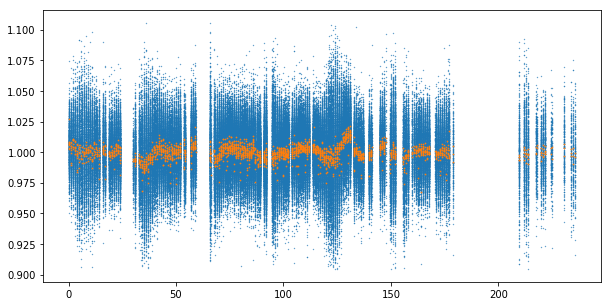

In [8]:
idx_ok = np.isfinite(df['rel_flux'])
obj.flux = df['rel_flux'][idx_ok]
obj.timeseries = df['hjd'][idx_ok] - df['hjd'][0]
obj.bin_data(delete_unbinned=False)
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(obj.timeseries, obj.flux, s=0.1)
ax.scatter(obj.timeseries_binned, obj.flux_binned, s=0.5)
plt.show()

In [10]:
torig, forig = obj.timeseries_binned, obj.flux_binned

In [11]:
print len(torig)

2432


In [34]:
t = torig
a = np.linspace(0, len(t)-1, len(t)).astype(int)
np.random.shuffle(a)
a

array([ 718, 1277, 1956, ..., 1950, 1313,   90])

In [12]:
def resample_timeseries(t, f, n=2000):
    temp = np.linspace(0, len(t)-1, len(t)).astype(int)
    np.random.shuffle(temp)
    idxs = sorted(temp[:n])
#     idxs = sorted(np.random.randint(0, len(t), len(t)))
    return np.array(t)[idxs], np.array(f)[idxs]

2000


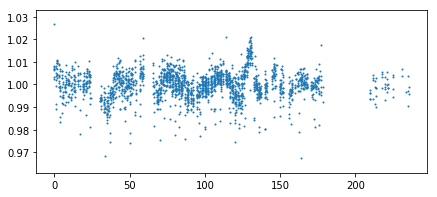

2000


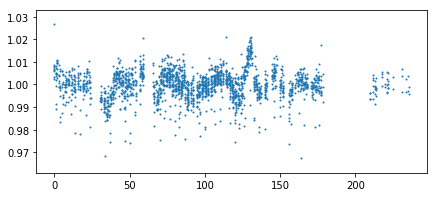

2000


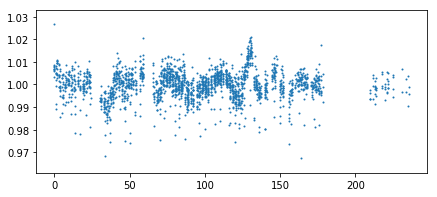

2000


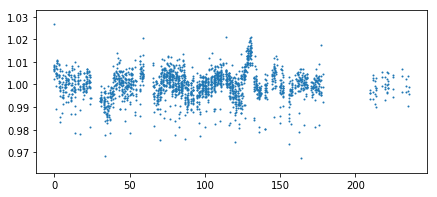

2000


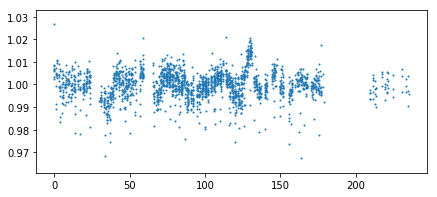

In [13]:
n = 5
for i in range(n):
    tt, ff = resample_timeseries(torig, forig)
    print len(tt)
    fig = plt.figure(figsize=(7, 3))
    plt.scatter(tt, ff, s=1)
    plt.show()

In [14]:
n = 5
periods = []
for i in range(n):
    obj = NGTSField(fieldname=fieldname, root_file=ROOT_DIR, object_list=[obj_id])[obj_id]
    obj.ok = True
    obj.logger = None
    tt, ff = resample_timeseries(torig, forig)
    obj.num_observations_binned = len(tt)
    obj.timeseries_binned = tt.tolist()
    obj.flux_binned = ff.tolist()
    obj.correlations = None
    obj.lag_timeseries = None
    obj.calculate_periods_from_autocorrelation()
    periods.append(obj.clean_periods())
print periods

[[17.156], [29.599], [17.036], [17.036], [17.237]]


In [25]:
p_outputs = [17.036, 17.231, 17.116, 17.116, 17.278, 17.036, 17.116, 16.958, 17.61, 16.903, 17.231, 16.926, 16.958, 17.321, 16.958, 17.359, 16.958, 17.278, 16.958, 17.196, 17.442, 17.196, 17.278, 17.116, 17.811, 17.036, 17.231, 17.116, 17.116, 17.278, 17.036, 17.116, 16.958, 17.61, 16.903, 17.231, 16.926, 16.958, 17.321, 16.958, 17.359, 16.958, 17.278, 16.958, 17.196, 17.442, 17.196, 17.278, 17.116, 17.811, 17.036, 17.231, 17.116, 17.116, 17.278, 17.036, 17.116, 16.958, 17.61, 16.903, 17.231, 16.926, 16.958, 17.321, 16.958, 17.359, 16.958, 17.278, 16.958, 17.196, 17.442, 17.196, 17.278, 17.116, 17.811, 17.036, 17.231, 17.116, 17.116, 17.278, 17.036, 17.116, 16.958, 17.61, 16.903, 17.231, 16.926, 16.958, 17.321, 16.958, 17.359, 16.958, 17.278, 16.958, 17.196, 17.442, 17.196, 17.278, 17.116, 17.811]

In [26]:
p_outputs = [p for p in p_outputs if 15<p<20]

In [27]:
print np.mean(p_outputs), np.std(p_outputs), np.std(p_outputs) / np.sqrt(len(p_outputs))

17.17544 0.21754578000963426 0.021754578000963427


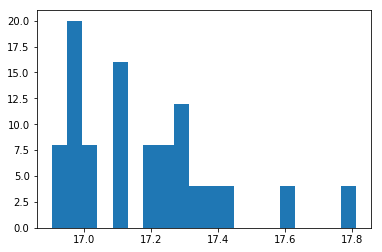

In [29]:
plt.hist(p_outputs, bins=20)
plt.show()

In [ ]:

for i in range(n-1):
    tt, ff = resample_timeseries(t, f)
    obj.timeseries_binned = 

In [15]:
tt

166.7727429312507

In [17]:
obj.calculate_periods_from_autocorrelation()

 ######      ###     ######  ######## 
##    ##    ## ##   ##    ## ##       
##         ##   ##  ##       ##       
##   #### ##     ## ##       ######   
##    ##  ######### ##       ##       
##    ##  ##     ## ##    ## ##       
 ######   ##     ##  ######  ##    
------------------------------
Number of Data Points: 2432
Number of Lag Timesteps: 67477
Lag Resolution: 0.00698631197868
------------------------------

 ######      ###     ######  ######## 
##    ##    ## ##   ##    ## ##       
##         ##   ##  ##       ##       
##   #### ##     ## ##       ######   
##    ##  ######### ##       ##       
##    ##  ##     ## ##    ## ##       
 ######   ##     ##  ######  ##    
------------------------------
Number of Data Points: 2432
Number of Lag Timesteps: 67477
Lag Resolution: 0.00698631197868
------------------------------



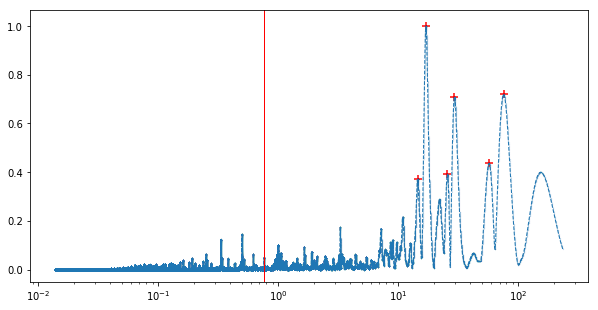

[17.056295854179353, 75.71761312010368, 29.516712442689624, 57.20393612001977, 25.74931131588763, 14.556739333075074]


In [57]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(obj.period_axis, obj.ft / max(obj.ft), marker='.', ls='--', lw=1, markersize=0.1)
ax.scatter(obj.period_axis[obj.peak_indexes], obj.ft[obj.peak_indexes]/max(obj.ft),marker='+', s=50, c='r')
ax.axvline(x=pplanet, c='r', lw=1)
ax.set_xscale('log')
plt.show()
print obj.periods

In [18]:
obj.clean_periods()

Altered 17.0562958542 to 17.036462952
Altered 17.0562958542 to 17.036462952
Most likely periods [17.036]
Most likely periods [17.036]


[17.036]

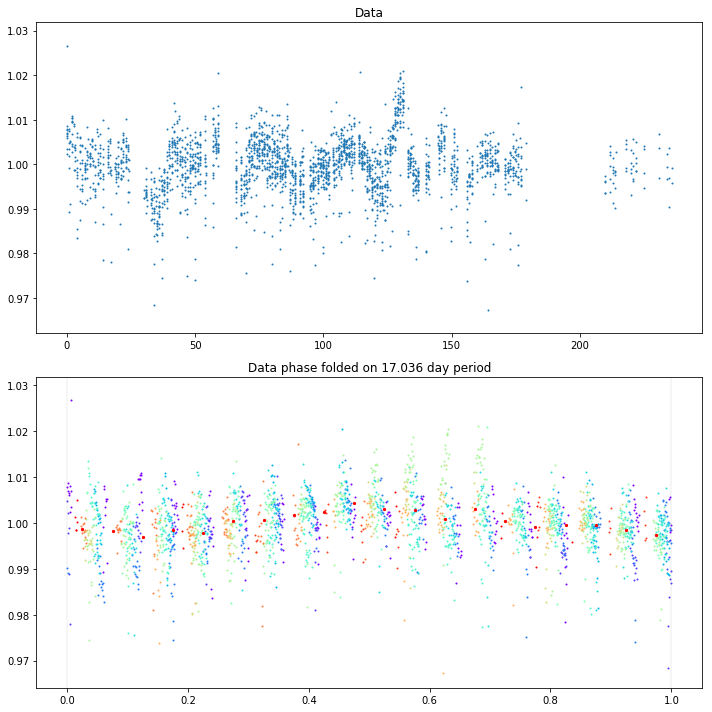

In [17]:
 t = obj.timeseries_binned
f = obj.flux_binned
p = obj.cleaned_refined_periods[0]
phase_app, data_app = utils.append_to_phase(utils.create_phase(t, p, 0), f, 0)
binned_phase_app, binned_data_app = utils.bin_phase_curve(phase_app, data_app)
ndata = len(phase_app)
idx = [i for i in range(1,ndata) if phase_app[i]<phase_app[i-1] ]
idx.append(ndata-1)
nidx = len(idx)
colours = mpl.cm.rainbow(np.r_[0:1:nidx*1j])
phases, fs = [], []

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
ax1.scatter(t-t[0], f, s=1)
ax1.set_title('Data'.format(p))
j=0
for k,i in enumerate(idx):
    phases.append( np.array(phase_app[j:i]) )
    fs.append( np.array(f[j:i]) )
    ax2.scatter(phases[k], fs[k], marker='o', s=1, c=colours[k])
    j=i
ax2.scatter(binned_phase_app, binned_data_app, s=5, c='r')
ax2.axvline(x=0, lw=0.1, c='k', ls='--')
ax2.axvline(x=1, lw=0.1, c='k', ls='--')
ax2.set_title('Data phase folded on {} day period'.format(p))
fig.tight_layout()
plt.show()

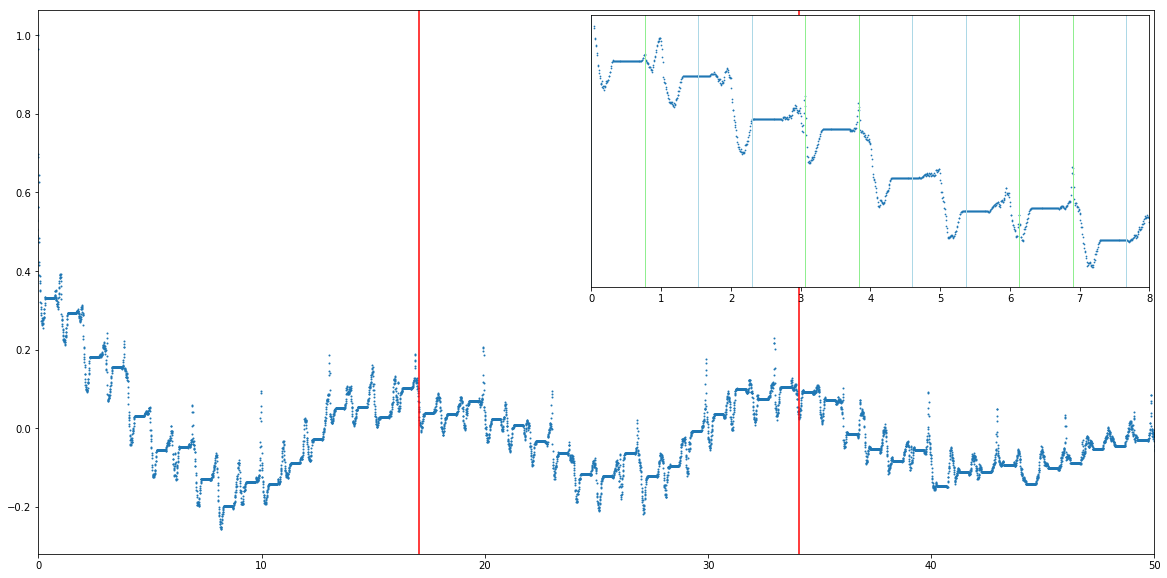

In [54]:
lag_timeseries = obj.lag_timeseries
correlations = obj.correlations

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
prot = 17.036
pplanet = 0.76689
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(lag_timeseries, correlations, s=1)
ax.axvline(x=prot, c='r')
ax.axvline(x=2*prot, c='r')
ax.set_xlim([0, 50])

axins = inset_axes(ax, width="50%", height="50%", loc=1)
axins.set_yticks([])

axins.scatter(lag_timeseries, correlations, s=0.5)
axins.set_xlim([0,8])
axins.set_ylim([-0.25, 0.45])

for i in range(15):
    poverlap = [1, 4, 5, 8, 9]
    colour = 'lightgreen' if i in poverlap else 'lightblue'
    axins.axvline(x=i*pplanet, lw=1, c=colour)
#     ax.axvline(x=-i, lw=1, c='lightblue')
plt.show()

In [53]:
df = pd.DataFrame()
df['lag_timeseries'] = lag_timeseries
df['correlations'] = correlations
df.to_csv('NOI_101123_ACF.csv', index=False)

,lag_timeseries,correlations
0,-235.706999,0.002599
1,-235.700012,0.002594
2,-235.693026,0.002571
3,-235.686040,0.002571
4,-235.679053,0.002651
